In [6]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

import time
import numpy as np

from plot_utils import plot_confusion_matrix, imshow, plot_losses
import torch as th
from torch.autograd import Variable
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [3]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 20000 # Max: 50 000 - n_val_samples
n_val_samples = 5000
n_test_samples = 5000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

In [5]:
num_workers = 2
test_batch_size = 4

#data augmentation
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, sampler=test_sampler,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
class LinearClassifier(nn.Module):
    """
    Linear Classifier
    """
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(32 * 32 * 3, 10)

    def forward(self, x):
        # Flatten input 3x32x32 -> 3072
        x = x.view(x.size(0), -1)
        return self.linear(x)

In [8]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

In [9]:
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# Use larger batchsize for validation to speed up computation
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler,
                                          num_workers=num_workers)

In [10]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param  net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
            total_train_loss += loss.data[0]

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        ## Do a pass on the validation set
        for inputs, labels in val_loader:
            # Wrap Tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            # Forward pass
            predictions = net(inputs)
            val_loss = criterion(predictions, labels)
            total_val_loss += val_loss.data[0]
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(th.load(best_model_path))
    
    return train_history, val_history

In [11]:
def dataset_accuracy(net, data_loader, name=""):
    correct = 0
    total = 0
    for data in data_loader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * correct / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")  
    
def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)
    
print("Computing accuracy...")
compute_accuracy(net)

Computing accuracy...


NameError: name 'net' is not defined

In [12]:
def accuracy_per_class(net):
    n_classes = 10
    class_correct = list(0. for i in range(n_classes))
    class_total = list(0. for i in range(n_classes))
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for data in test_loader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(test_batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        print('{:<10} {:^10.2f}'.format(
            classes[i], 100 * class_correct[i] / class_total[i]))
    return confusion_matrix

confusion_matrix = accuracy_per_class(net)

NameError: name 'net' is not defined

In [13]:
def get_output_size(in_size, kernel_size, stride=1, padding=0):
    """
    Get the output size given all the parameters of the convolution
    :param in_size: (int) input size
    :param kernel_size: (int)
    :param stride: (int)
    :param paddind: (int)
    :return: (int)
    """
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

In [ ]:
class MyConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        #### START CODE: ADD NEW LAYERS ####
        #IN_V1
        self.v1pool1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.v1conv1 = nn.Conv2d(18, 16, kernel_size=1, stride=1, padding=0)
        
        self.v1conv2 = nn.Conv2d(18, 8, kernel_size=1, stride=1, padding=0)
        self.v1conv22 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2)
        
        self.v1conv3 = nn.Conv2d(18, 48, kernel_size=1, stride=1, padding=0)
        self.v1conv32 = nn.Conv2d(48, 64, kernel_size=3, stride=1, padding=1)
        
        self.v1conv4 = nn.Conv2d(18, 32, kernel_size=1, stride=1, padding=0)
        
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3, padding=1)
        #IN_V2 6 6 128   6 6 256
        self.v2pool1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.v2conv1 = nn.Conv2d(128, 32, kernel_size=1, stride=1, padding=0)
        
        self.v2conv2 = nn.Conv2d(128, 16, kernel_size=1, stride=1, padding=0)
        self.v2conv22 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        
        self.v2conv3 = nn.Conv2d(128, 96, kernel_size=1, stride=1, padding=0)
        self.v2conv32 = nn.Conv2d(96, 128, kernel_size=3, stride=1, padding=1)
        
        self.v2conv4 = nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0)
        
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=3, padding=0)
        #IN_V3 2 2 256 2 2 512
        self.v3pool1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.v3conv1 = nn.Conv2d(256, 64, kernel_size=1, stride=1, padding=0)
        
        self.v3conv2 = nn.Conv2d(256, 32, kernel_size=1, stride=1, padding=0)
        self.v3conv22 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        
        self.v3conv3 = nn.Conv2d(256, 192, kernel_size=1, stride=1, padding=0)
        self.v3conv32 = nn.Conv2d(192, 256, kernel_size=3, stride=1, padding=1)
        
        self.v3conv4 = nn.Conv2d(256, 128, kernel_size=1, stride=1, padding=0)
        
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Size of the output of the last convolution:
        self.flattened_size = 512
        ### END CODE ###
        
        self.fc1 = nn.Linear(self.flattened_size, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool1(x)
        #IN_V1
        x1 = self.v1pool1(x)
        x1 = self.v1conv1(x1)
        
        x2 = self.v1conv2(x)
        x2 = self.v1conv22(x2)
        
        x3 = self.v1conv3(x)
        x3 = self.v1conv32(x3)
        
        x4 = self.v1conv4(x)

        x = F.relu(torch.cat((x1,x2,x3,x4),1))
        x = self.pool2(x)
        
        #IN_V2
        x1 = self.v2pool1(x)
        x1 = self.v2conv1(x1)
        
        x2 = self.v2conv2(x)
        x2 = self.v2conv22(x2)
        
        x3 = self.v2conv3(x)
        x3 = self.v2conv32(x3)
        
        x4 = self.v2conv4(x)
        
        x = F.relu(torch.cat((x1,x2,x3,x4),1))
        x = self.pool3(x)
        #IN_V3
        x1 = self.v3pool1(x)
        x1 = self.v3conv1(x1)
        
        x2 = self.v3conv2(x)
        x2 = self.v3conv22(x2)
        
        x3 = self.v3conv3(x)
        x3 = self.v3conv32(x3)
        
        x4 = self.v3conv4(x)
        
        x = F.relu(torch.cat((x1,x2,x3,x4),1))
        x = self.pool4(x)

        
        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)
        
        # 18x16x16 -> 4608
        x = x.view(-1, self.flattened_size)
        # 4608 -> 64
        x = F.dropout(x, training=self.training)
        # 64 -> 10
        x = self.fc1(x)
        return x

In [21]:
def squash(s, dim = 2):
    s1 = torch.sum(s**2, dim, keepdim=True)
    s2 = torch.sqrt(s)
    out = (s1/(1.0 + s1))*(s/s2)
    return out

def softmax(input, dim=1):
    input_size = input.size()

    trans_input = input.transpose(dim, len(input_size) - 1)
    trans_size = trans_input.size()
    input_2d = trans_input.contiguous().view(-1, trans_size[-1])
    soft_max_2d = F.softmax(input_2d)
    soft_max_nd = soft_max_2d.view(*trans_size)

    return soft_max_nd.transpose(dim, len(input_size) - 1)

In [42]:
class Capsule(nn.Module):
    def __init__(self):
        super(Capsule, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(256, 32 , 9, 2) for u in range(8)
        ])

    def forward(self, x):
        
        #input size 32*32*256 output size 12*12*32
        #8 units in total
        temp = [self.convs[i](x) for i,l in enumerate(self.convs)]
        #stack the 8 units to shape 128*8*32*12*12
        x = torch.stack(temp, dim = 1)
        batchsize = x.size(0)
        #into shape 128*8*4608
        #into shape 128*8*4608
        x = x.view(batchsize, 8, -1)
        #use squash function
        x = squash(x, dim=2)
        return x

class Capsule_routing(nn.Module):
    def __init__(self):
        # 1*4608*10*16*8
        # inchannel num_unit unit_size in_unit
        super(Capsule_routing, self).__init__()
        self.weight = nn.Parameter(torch.randn(1,4608,10,16,8))

    def forward(self, x):
        batchsize = x.size(0)
        # output shape 128*4608*8
        x = x.transpose(1,2)
        # output shape 128*4608*10*8*1
        x = torch.stack([x]*10, dim=2).unsqueeze(4)
        # change weight size to 128*4608*10*16*8
        batch_weight = torch.cat([self.weight]*batchsize, dim=0)
        # u_hat shape 128*4608*10*16*1
        u_hat = torch.matmul(batch_weight, x)
        bij = Variable(torch.zeros(1,4608,10,1))
        num_routing = 3
        for i in range(num_routing):
            cij = softmax(bij, dim=2)
            cij = torch.cat([cij]*batchsize,dim=0).unsqueeze(4)
            sj = (cij*u_hat).sum(dim=1,keepdim=True)
            #cij 128*4608*10*1*1  sj 128*1*10*16*1
            vj = squash(sj , dim=3)
            vj1 = torch.cat([vj]*4608,dim=1)
            uvj1 = torch.matmul(u_hat.transpose(3,4), vj1).squeeze(4).mean(dim=0,keepdim=True)
            
            bij = bij + uvj1
        #return 128*10*16
        x = vj.squeeze(1).squeeze(3)
        x = x.sum(2)
        return x.squeeze(2)


class MyCapNetwork(nn.Module):
    def __init__(self):
        super(MyCapNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 256, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
        #### START CODE: ADD NEW LAYERS ####
        #Capsule Network
        self.cap = Capsule()
        self.caprouting = Capsule_routing()
        
    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool1(x)
        #IN_V1
        x = self.cap(x)
        x = self.caprouting(x)

        return x

In [43]:
net = MyCapNetwork()
train_history, val_history = train(net, batch_size=128, n_epochs=1, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 128
n_epochs= 1
learning_rate= 0.001


RuntimeError: $ Torch: not enough memory: you tried to allocate 1GB. Buy new RAM! at /pytorch/torch/lib/TH/THGeneral.c:270

In [111]:
net = MyConvolutionalNetwork()
train_history, val_history = train(net, batch_size=128, n_epochs=40, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 128
n_epochs= 40
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.43 took: 61.92s
Epoch 1, 20% 	 train_loss: 2.30 took: 57.77s
Epoch 1, 30% 	 train_loss: 2.15 took: 52.24s
Epoch 1, 40% 	 train_loss: 2.10 took: 48.89s
Epoch 1, 50% 	 train_loss: 2.03 took: 45.02s
Epoch 1, 61% 	 train_loss: 1.99 took: 44.74s
Epoch 1, 71% 	 train_loss: 1.89 took: 44.74s
Epoch 1, 81% 	 train_loss: 1.85 took: 44.69s
Epoch 1, 91% 	 train_loss: 1.86 took: 44.96s
Validation loss = 1.67
Epoch 2, 10% 	 train_loss: 1.74 took: 46.20s
Epoch 2, 20% 	 train_loss: 1.67 took: 45.15s
Epoch 2, 30% 	 train_loss: 1.65 took: 45.08s
Epoch 2, 40% 	 train_loss: 1.64 took: 44.93s
Epoch 2, 50% 	 train_loss: 1.59 took: 45.18s
Epoch 2, 61% 	 train_loss: 1.61 took: 44.83s
Epoch 2, 71% 	 train_loss: 1.58 took: 46.66s
Epoch 2, 81% 	 train_loss: 1.47 took: 44.85s
Epoch 2, 91% 	 train_loss: 1.54 took: 44.96s
Validation loss = 1.40
Epoch 3, 10% 	 train_loss: 1.47 took: 46.00s
Epoch 3, 20% 	 train_

Epoch 19, 81% 	 train_loss: 0.68 took: 45.17s
Epoch 19, 91% 	 train_loss: 0.62 took: 45.28s
Validation loss = 0.78
Epoch 20, 10% 	 train_loss: 0.58 took: 45.99s
Epoch 20, 20% 	 train_loss: 0.58 took: 45.20s
Epoch 20, 30% 	 train_loss: 0.62 took: 44.97s
Epoch 20, 40% 	 train_loss: 0.64 took: 45.37s
Epoch 20, 50% 	 train_loss: 0.61 took: 44.98s
Epoch 20, 61% 	 train_loss: 0.67 took: 45.08s
Epoch 20, 71% 	 train_loss: 0.65 took: 45.45s
Epoch 20, 81% 	 train_loss: 0.62 took: 45.17s
Epoch 20, 91% 	 train_loss: 0.59 took: 45.18s
Validation loss = 0.80
Epoch 21, 10% 	 train_loss: 0.58 took: 46.10s
Epoch 21, 20% 	 train_loss: 0.56 took: 47.29s
Epoch 21, 30% 	 train_loss: 0.60 took: 45.20s
Epoch 21, 40% 	 train_loss: 0.59 took: 45.55s
Epoch 21, 50% 	 train_loss: 0.61 took: 45.24s
Epoch 21, 61% 	 train_loss: 0.60 took: 45.18s
Epoch 21, 71% 	 train_loss: 0.62 took: 45.57s
Epoch 21, 81% 	 train_loss: 0.64 took: 45.19s
Epoch 21, 91% 	 train_loss: 0.62 took: 45.29s
Validation loss = 0.77
Epoch 22, 1

Epoch 38, 61% 	 train_loss: 0.42 took: 45.14s
Epoch 38, 71% 	 train_loss: 0.39 took: 45.33s
Epoch 38, 81% 	 train_loss: 0.43 took: 45.33s
Epoch 38, 91% 	 train_loss: 0.43 took: 45.48s
Validation loss = 0.86
Epoch 39, 10% 	 train_loss: 0.40 took: 46.02s
Epoch 39, 20% 	 train_loss: 0.41 took: 45.50s
Epoch 39, 30% 	 train_loss: 0.43 took: 45.11s
Epoch 39, 40% 	 train_loss: 0.39 took: 45.08s
Epoch 39, 50% 	 train_loss: 0.41 took: 45.53s
Epoch 39, 61% 	 train_loss: 0.43 took: 45.15s
Epoch 39, 71% 	 train_loss: 0.48 took: 45.12s
Epoch 39, 81% 	 train_loss: 0.43 took: 45.11s
Epoch 39, 91% 	 train_loss: 0.43 took: 45.39s
Validation loss = 0.90
Epoch 40, 10% 	 train_loss: 0.40 took: 46.06s
Epoch 40, 20% 	 train_loss: 0.38 took: 45.63s
Epoch 40, 30% 	 train_loss: 0.39 took: 45.22s
Epoch 40, 40% 	 train_loss: 0.37 took: 45.13s
Epoch 40, 50% 	 train_loss: 0.38 took: 45.51s
Epoch 40, 61% 	 train_loss: 0.42 took: 45.03s
Epoch 40, 71% 	 train_loss: 0.40 took: 45.15s
Epoch 40, 81% 	 train_loss: 0.43 t

### Losses Plot

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


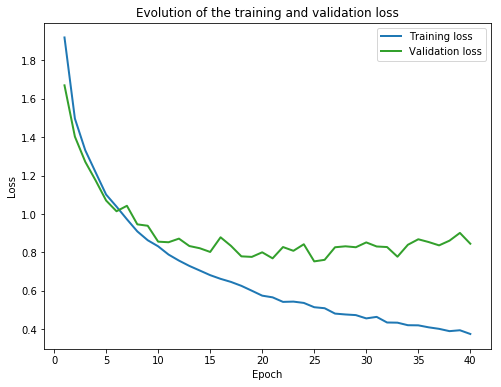

In [112]:
plot_losses(train_history, val_history)

### Accuracy of the trained model

In [113]:
compute_accuracy(net)

Accuracy of the network on the 20000 train images: 83.42 %
Accuracy of the network on the 5000 validation images: 75.80 %
Accuracy of the network on the 5000 test images: 73.52 %


**Baseline: Simple Convolutional Neural Network (form part II)**

<table>
<tr>
    <td>Accuracy on the test set:</td>
    <td>60.80 %</td>
</tr>
</table>

In [73]:
confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        80.12   
car          82.57   
bird         57.81   
cat          63.98   
deer         55.23   
dog          50.41   
frog         65.38   
horse        64.44   
ship         76.79   
truck        79.73   


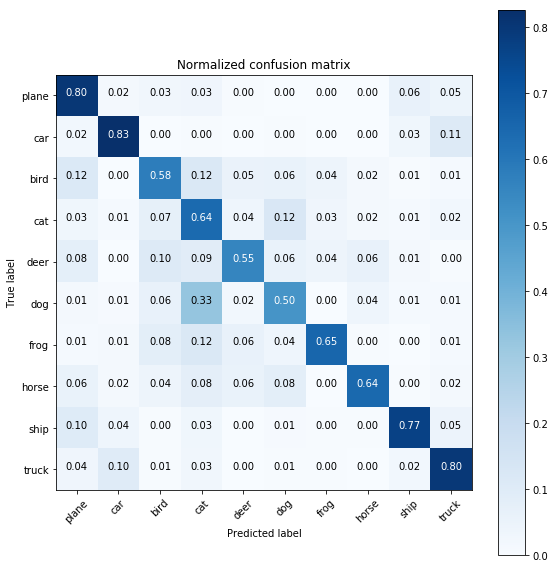

In [74]:
#plot_confusion_matrix(confusion_matrix, classes,
#                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Normalized confusion matrix')


### Going further

- [Coursera Course on CNN](https://www.coursera.org/learn/convolutional-neural-networks)
- [Standford Course](http://cs231n.stanford.edu/syllabus.html)
- [PyTorch Tutorial](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)